In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
    pairs_from_exhaustive,
)
import torch
from hloc.utils import viz_3d
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available:  {torch.cuda.is_available()}")
print(f"Device Name:     {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

PyTorch Version: 2.9.1+cu128
CUDA Available:  True
Device Name:     NVIDIA GeForce RTX 4070 Ti


## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [ ]:
images = Path("images_1s/")
outputs = Path("outputs/sfm/")
sfm_pairs = outputs / "pairs-netvlad.txt"
sfm_dir = outputs / "sfm_superpoint+superglue"

retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["superpoint_aachen"]
matcher_conf = match_features.confs["superglue"]

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data and refined with SfM.

In [3]:
if not images.exists():
    !wget https://cvg-data.inf.ethz.ch/local-feature-evaluation-schoenberger2017/South-Building.zip -P datasets/
    !unzip -q datasets/South-Building.zip -d datasets/

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the most similar ones. For smaller dataset we can instead use exhaustive matching via `hloc/pairs_from_exhaustive.py`, which would find $\frac{n(n-1)}{2}$ images pairs.

In [4]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=30)

[2025/12/16 17:37:20 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2025/12/16 17:37:20 hloc INFO] Found 455 images in root images_0.3s.
100%|██████████| 455/455 [00:38<00:00, 11.93it/s]
[2025/12/16 17:38:04 hloc INFO] Finished exporting features.
[2025/12/16 17:38:04 hloc INFO] Extracting image pairs from a retrieval database.
[2025/12/16 17:38:05 hloc INFO] Found 13650 pairs.


## Extract and match local features

In [5]:
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs
)

# feature_path = extract_features.main(feature_conf, images, outputs)
# pairs_from_exhaustive.main(sfm_pairs, features=feature_path)
# match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf["output"], outputs)

[2025/12/16 17:38:09 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2025/12/16 17:38:09 hloc INFO] Found 455 images in root images_0.3s.


Loaded SuperPoint model


100%|██████████| 455/455 [00:18<00:00, 24.98it/s]
[2025/12/16 17:38:27 hloc INFO] Finished exporting features.
[2025/12/16 17:38:27 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 7829/7829 [08:48<00:00, 14.81it/s]
[2025/12/16 17:47:16 hloc INFO] Finished exporting matches.


## 3D reconstruction
Run COLMAP on the features and matches.

In [8]:
# Check if all prerequisites exist before running reconstruction
print("Checking prerequisites for reconstruction...")
print(f"Images folder exists: {images.exists()}")
print(f"Pairs file exists: {sfm_pairs.exists()}")
print(f"Feature file exists: {feature_path.exists()}")
print(f"Match file exists: {match_path.exists()}")

if images.exists():
    image_files = list(images.glob("*.[jJ][pP][gG]")) + list(images.glob("*.[pP][nN][gG]"))
    print(f"Number of images found: {len(image_files)}")
    
if sfm_pairs.exists():
    with open(sfm_pairs, 'r') as f:
        pairs_content = f.read().strip()
        num_pairs = len([l for l in pairs_content.split('\n') if l.strip()])
        print(f"Number of image pairs: {num_pairs}")
        if num_pairs == 0:
            print("WARNING: No pairs found! This will cause reconstruction to fail.")

Checking prerequisites for reconstruction...
Images folder exists: True
Pairs file exists: True
Feature file exists: True
Match file exists: True
Number of images found: 455
Number of image pairs: 13650


In [9]:
# Inspect the COLMAP database
import pycolmap

database_path = sfm_dir / "database.db"

if database_path.exists():
    print(f"Database found at: {database_path}")
    print(f"Database size: {database_path.stat().st_size / 1024:.2f} KB\n")
    
    try:
        with pycolmap.Database.open(database_path) as db:
            num_cameras = db.num_cameras()
            num_images = db.num_images()
            num_keypoints = sum([db.read_keypoints(img.image_id).shape[0] 
                                for img in db.read_all_images()])
            num_matches = sum([db.read_matches(img1.image_id, img2.image_id).shape[0]
                              for img1 in db.read_all_images()
                              for img2 in db.read_all_images()
                              if img1.image_id < img2.image_id and 
                              db.exists_matches(img1.image_id, img2.image_id)])
            
            print("Database contents:")
            print(f"  - Cameras: {num_cameras}")
            print(f"  - Images: {num_images}")
            print(f"  - Total keypoints: {num_keypoints}")
            print(f"  - Match pairs: {num_matches}")
            
            if num_images == 0:
                print("\n⚠️  WARNING: Database has no images!")
            if num_matches == 0:
                print("\n⚠️  WARNING: Database has no matches!")
                
    except Exception as e:
        print(f"Error reading database: {e}")
        print("\n⚠️  The database might be corrupted!")
else:
    print(f"No database found at: {database_path}")
    print("The database will be created when you run reconstruction.")

print("\n" + "="*60)
print("If you want to reset and start fresh, uncomment and run:")
print("# if database_path.exists(): database_path.unlink()")
print("# if sfm_dir.exists(): import shutil; shutil.rmtree(sfm_dir)")
print("="*60)

No database found at: outputs\sfm\sfm_superpoint+superglue\database.db
The database will be created when you run reconstruction.

If you want to reset and start fresh, uncomment and run:
# if database_path.exists(): database_path.unlink()
# if sfm_dir.exists(): import shutil; shutil.rmtree(sfm_dir)


In [10]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

if model is None:
    print("\n" + "="*60)
    print("ERROR: Reconstruction failed!")
    print("="*60)
    print("\nPossible causes:")
    print("1. Not enough matching images")
    print("2. Poor quality matches")
    print("3. Incorrect image paths")
    print("4. Check the logs in:", sfm_dir / "colmap.LOG.INFO")
    print("\nTips:")
    print("- Make sure your images folder path is correct")
    print("- Try increasing num_matched in pairs_from_retrieval")
    print("- Check if feature extraction and matching completed successfully")
else:
    print("\n" + "="*60)
    print("Reconstruction successful!")
    print("="*60)
    print(f"\nModel saved to: {sfm_dir}")
    print(f"Number of 3D points: {model.num_points3D()}")
    print(f"Number of registered images: {model.num_reg_images()}")
    print(f"Number of cameras: {model.num_cameras()}")

[2025/12/16 17:48:45 hloc INFO] Writing COLMAP logs to outputs\sfm\sfm_superpoint+superglue\colmap.LOG.*
[2025/12/16 17:48:45 hloc INFO] Creating an empty database...
[2025/12/16 17:48:45 hloc INFO] Importing images into the database...
[2025/12/16 17:49:02 hloc INFO] Importing features into the database...
100%|██████████| 455/455 [00:00<00:00, 1438.74it/s]
[2025/12/16 17:49:02 hloc INFO] Importing matches into the database...
100%|██████████| 13650/13650 [00:06<00:00, 2058.96it/s]
[2025/12/16 17:49:09 hloc INFO] Performing geometric verification of the matches...
[2025/12/16 17:50:00 hloc INFO] Running 3D reconstruction...
Reconstruction 6:   1%|          | 3/455 [00:00<01:24,  5.34images/s, registered]
Reconstruction 7: 474images [1:05:03,  8.24s/images, registered]                     
[2025/12/16 18:55:22 hloc INFO] Reconstructed 2 model(s).
[2025/12/16 18:55:22 hloc INFO] Largest model is #1 with 451 images.
[2025/12/16 18:55:22 hloc INFO] Reconstruction statistics:
Reconstructio


Reconstruction successful!

Model saved to: outputs\sfm\sfm_superpoint+superglue
Number of 3D points: 56370
Number of registered images: 451
Number of cameras: 451


## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

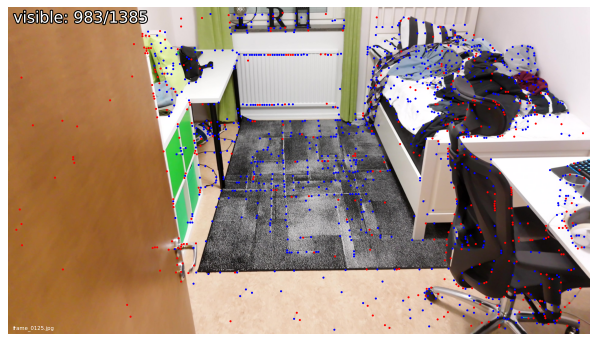

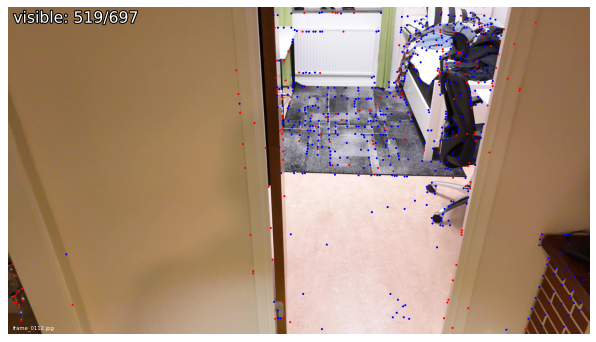

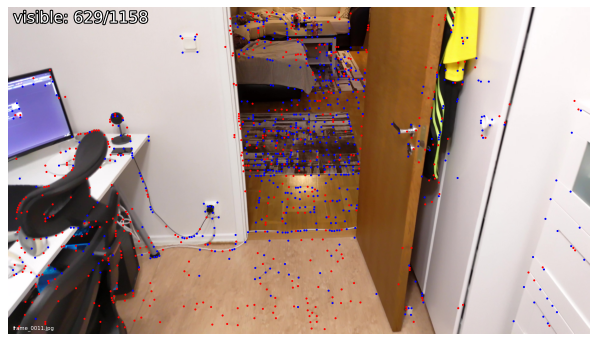

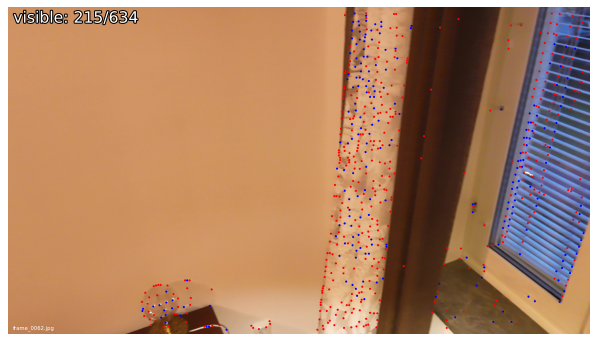

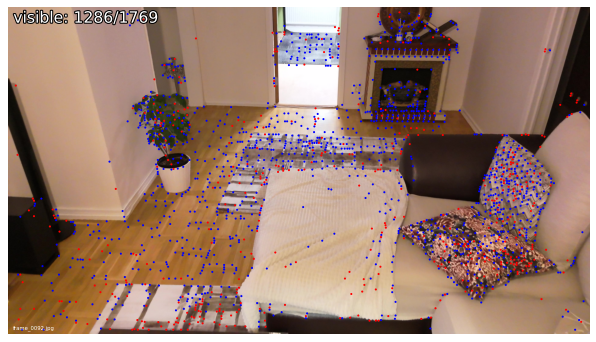

In [9]:

visualization.visualize_sfm_2d(model, images, color_by="visibility", n=5)

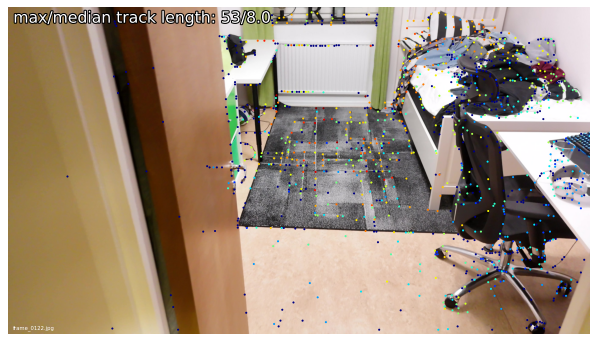

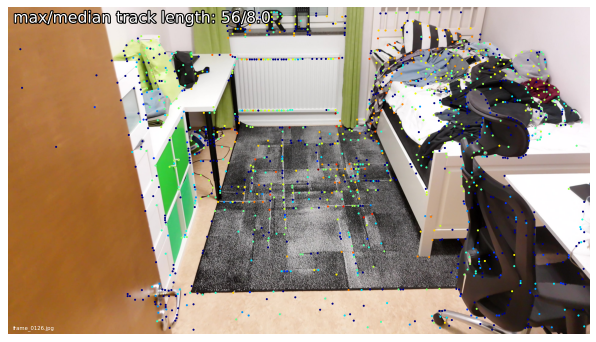

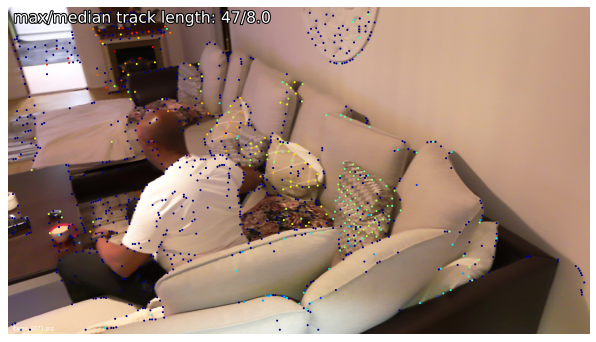

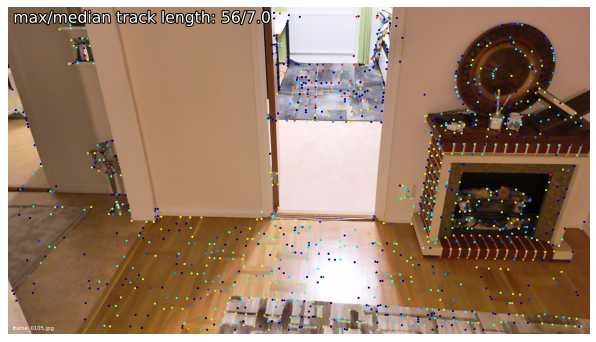

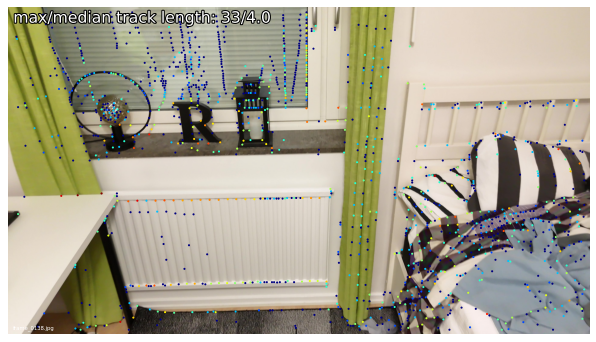

In [11]:
visualization.visualize_sfm_2d(model, images, color_by="track_length", n=5)

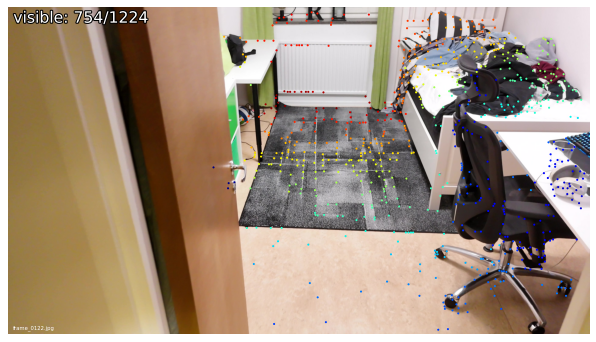

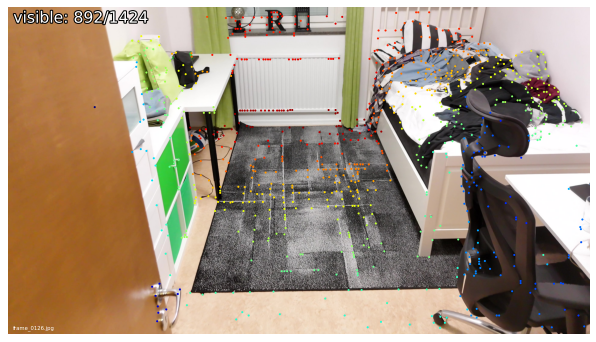

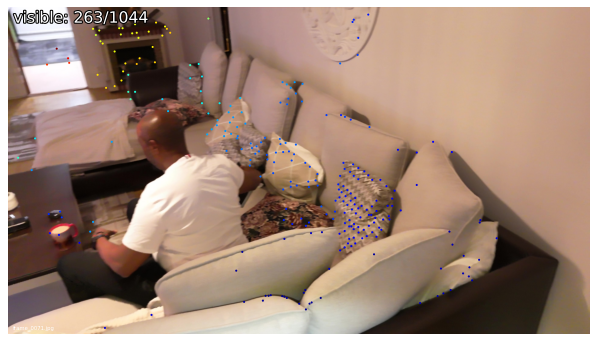

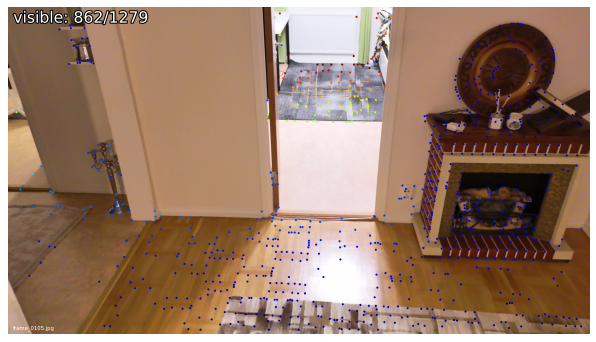

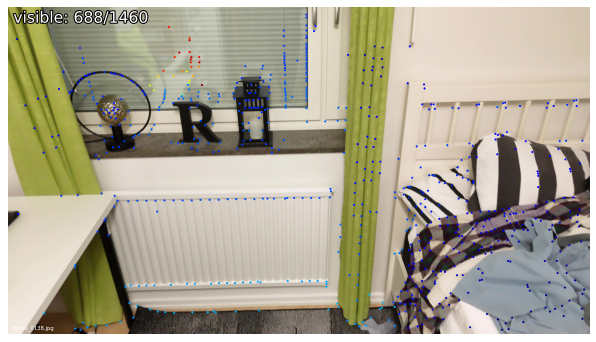

In [12]:
visualization.visualize_sfm_2d(model, images, color_by="depth", n=5)

In [12]:
import pycolmap
from pathlib import Path

outputs = Path("outputs/sfm_1s/") 
sfm_dir = outputs / "sfm_superpoint+superglue"
models_dir = sfm_dir / "models"

# Check for models in the models/ subfolder
if models_dir.exists():
    model_folders = sorted([d for d in models_dir.iterdir() if d.is_dir()], 
                          key=lambda x: int(x.name))
    
    if model_folders:
        print(f"Found {len(model_folders)} reconstruction models in {models_dir}:\n")
        
        # Show statistics for each model
        model_stats = []
        for model_folder in model_folders:
            try:
                rec = pycolmap.Reconstruction(model_folder)
                model_stats.append({
                    'id': model_folder.name,
                    'rec': rec,
                    'points': rec.num_points3D(),
                    'images': rec.num_reg_images(),
                    'cameras': rec.num_cameras()
                })
                print(f"Model {model_folder.name}:")
                print(f"  - 3D points: {rec.num_points3D()}")
                print(f"  - Registered images: {rec.num_reg_images()}")
                print(f"  - Cameras: {rec.num_cameras()}\n")
            except Exception as e:
                print(f"Model {model_folder.name}: Error loading - {e}\n")
        
        # Load the largest model (by number of registered images)
        if model_stats:
            largest = max(model_stats, key=lambda x: x['images'])
            #load model
            print("="*60)
            print(f"Loading largest model (Model {largest['id']}) for visualization...")
            print("="*60)
            model = largest['rec']
            
            if model.num_points3D() > 0:
                fig = viz_3d.init_figure()
                viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', 
                                         name=f"model_{largest['id']}", points_rgb=True)
                fig.show()
            else:
                print("\nNo 3D points to visualize in this model.")
                
# Also check if model was moved to main sfm_dir
elif (sfm_dir / "cameras.bin").exists():
    print(f"Loading model from {sfm_dir}...")
    model = pycolmap.Reconstruction(sfm_dir)
    print(model.summary())
    
    if model.num_points3D() > 0:
        fig = viz_3d.init_figure()
        viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', 
                                 name="mapping", points_rgb=True)
        fig.show()
    else:
        print("\nNo 3D points to visualize.")
else:
    print(f"No models found in {sfm_dir} or {models_dir}")
    print("Please run the reconstruction step first.")

Found 2 reconstruction models in outputs\sfm_1s\sfm_superpoint+superglue\models:

Model 0:
  - 3D points: 27485
  - Registered images: 157
  - Cameras: 157

Model 1: Error loading - [reconstruction.cc:734] rigs, cameras, frames, images, points3D files do not exist at outputs\sfm_1s\sfm_superpoint+superglue\models\1

Loading largest model (Model 0) for visualization...
